<a href="https://colab.research.google.com/github/PerlaMolina/BMI212-AURA/blob/main/(final)Early_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Lan Lan wrote the code in this notebook.
# load data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/widsdata/'
behavorial_data = pd.read_excel(file_path+'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
label_data = pd.read_excel(file_path+'TRAINING_SOLUTIONS.xlsx')
FC_data = pd.read_csv(file_path+ 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
FC_reduced = pd.read_csv(file_path+ 'autoencoder/FC_extracted.csv')

Mounted at /content/drive/


## Data Splitting and Preprocessing
see the same section in Late_Fusion notebook for explanation

In [2]:
import pandas as pd
import numpy as np
from random import seed
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 0
seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
# merge everything first because need to drop subject with nan entries for all data
all_data_with_label = pd.merge(behavorial_data, label_data, how= 'left', on= ['participant_id'])
all_data_with_label = pd.merge(all_data_with_label, FC_data, how= 'left', on= ['participant_id']) # merge with raw FC data
all_data_with_label = pd.merge(all_data_with_label, FC_reduced, how= 'left', on= ['participant_id']) # merge with extracted FC data
all_data_with_label['stratify'] = all_data_with_label['Sex_F'].astype(str) + '_' + all_data_with_label['ADHD_Outcome'].astype(str)
# drop NAN
all_data_with_label = all_data_with_label.dropna()
# drop columns not related to ADHD: "EHQ_EHQ_Total" - Laterality Index (Score), "ColorVision_CV_Score" - Color vision test score
all_data_with_label = all_data_with_label.drop(columns=['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan'])

# before splitting, standardize behavorial features

behavorial_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]


scaler = StandardScaler()
all_data_with_label[behavorial_columns_names] = scaler.fit_transform(all_data_with_label[behavorial_columns_names])


# splitting
train_all_subjects_raw, test_all_subjects_raw = train_test_split(all_data_with_label, test_size=0.3, stratify=all_data_with_label['stratify'])
print('training:')
print(train_all_subjects_raw['stratify'].value_counts())
print('testing:')
print(test_all_subjects_raw['stratify'].value_counts())
train_all_subjects_raw.reset_index(drop=True, inplace=True)
test_all_subjects_raw.reset_index(drop=True, inplace=True)

# training data for all subjects
train_data_all_subjects_X = train_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify', 'Unnamed: 0'])
train_data_all_subjects_y = train_all_subjects_raw['ADHD_Outcome']

# training data for female
train_data_female_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_female_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']


# training data for male
train_data_male_X = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
train_data_male_y = train_all_subjects_raw[train_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']

# testing data for all subjects
test_data_all_subjects_X = test_all_subjects_raw.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_all_subjects_y = test_all_subjects_raw['ADHD_Outcome']

# testing data for female
test_data_female_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1].drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_female_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 1]['ADHD_Outcome']

# testing data for male
test_data_male_X = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0].drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F', 'stratify'])
test_data_male_y = test_all_subjects_raw[test_all_subjects_raw['Sex_F'] == 0]['ADHD_Outcome']

training:
stratify
0_1    274
1_1    115
0_0    102
1_0     77
Name: count, dtype: int64
testing:
stratify
0_1    118
1_1     49
0_0     44
1_0     33
Name: count, dtype: int64


# concatenate multiple modalities

In [3]:
def make_data_dictionary(columns_to_select):

  #all variables not passed in are initialized perviously as global variables for this function
  data_dictionary = {
     'all_subjects': {
        'train_X': train_data_all_subjects_X[columns_to_select],
        'train_y': train_data_all_subjects_y,
        'test_X': test_data_all_subjects_X[columns_to_select],
        'test_y': test_data_all_subjects_y},
    'female': {
        'train_X': train_data_female_X[columns_to_select],
        'train_y': train_data_female_y,
        'test_X': test_data_female_X[columns_to_select],
        'test_y': test_data_female_y},
    'male': {
        'train_X': train_data_male_X[columns_to_select],
        'train_y': train_data_male_y,
        'test_X': test_data_male_X[columns_to_select],
        'test_y': test_data_male_y}
 }

  return data_dictionary

behavioral_columns_names = [x for x in behavorial_data.columns
                            if x not in ['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'MRI_Track_Age_at_Scan']]

raw_FC_columns_names = [x for x in FC_data.columns if 'row' in x and 'column' in x and 'th' in x]

reduced_FC_columns_names = [x for x in FC_reduced.columns if 'extracted_FC' in x]

behavioral_raw_FC_dict = make_data_dictionary(behavioral_columns_names + raw_FC_columns_names)
behavioral_extracted_FC_dict= make_data_dictionary(raw_FC_columns_names + reduced_FC_columns_names)

# loop through models with different kernels/regularization types

to find the best model (highest auroc) for each modality type and each cohort

In [5]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pickle
def return_model_list(model_name):
    if model_name == 'SVC':
        return [
            ('linear', SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)),
            ('poly', SVC(kernel='poly', random_state=RANDOM_STATE, probability=True)),
            ('rbf', SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True))
        ]
    elif model_name == 'LinearSVC':
        return [
            ('l1', LinearSVC(penalty='l1', dual=False, random_state=RANDOM_STATE,  max_iter=10000)),
            ('l2', LinearSVC(penalty='l2', random_state=RANDOM_STATE,  max_iter=10000)),
        ] # defaulted to l2, no 'none' option

    elif model_name == 'LogisticRegression':
        return [
            ('l1', LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE,  max_iter=10000)),
            ('l2', LogisticRegression(penalty='l2', random_state=RANDOM_STATE,  max_iter=10000)),
            ('elasticnet', LogisticRegression(penalty='elasticnet', l1_ratio= 0.5,
                                               random_state=RANDOM_STATE, solver= 'saga',  max_iter=10000)), # only saga supports elastic net
            ('none', LogisticRegression(penalty=None, random_state=RANDOM_STATE))
        ]
    else:
        return None

def make_dictionary_for_results():

  results = {
    'SVC': {
        'linear': None,
        'poly': None,
        'rbf': None
    },
    'LinearSVC': {
        'l1': None,
        'l2': None,
    },
    'LogisticRegression': {
        'l1': None,
        'l2': None,
        'elasticnet': None,
        'none': None
    }
 }

  return results



def modality_evaluation(FC_data_dictionary):
   # see which model subtype performs best on selected modalities

    models_names = ['SVC', 'LinearSVC', 'LogisticRegression']

    all_record = {}


    for cohort in FC_data_dictionary.keys():

      record_cohort = make_dictionary_for_results()

      for model_name in models_names:
          model_list = return_model_list(model_name)

          for subtype, model in model_list:

            model.fit(FC_data_dictionary[cohort]['train_X'], FC_data_dictionary[cohort]['train_y'])

            if model_name == 'LinearSVC':

              decision_values = model.decision_function(FC_data_dictionary[cohort]['test_X'])
              proba_positive = 1 / (1 + np.exp(-decision_values))
              auroc = roc_auc_score(FC_data_dictionary[cohort]['test_y'], proba_positive)
              bal_acc = balanced_accuracy_score(FC_data_dictionary[cohort]['test_y'],
                                            model.predict(FC_data_dictionary[cohort]['test_X']))
            else:
              auroc = roc_auc_score(FC_data_dictionary[cohort]['test_y'], model.predict_proba(FC_data_dictionary[cohort]['test_X'])[:, 1])

              bal_acc = balanced_accuracy_score(FC_data_dictionary[cohort]['test_y'],
                                            model.predict(FC_data_dictionary[cohort]['test_X']))

            record_cohort[model_name][subtype] = (auroc, bal_acc)

      all_record[cohort] = record_cohort

    return all_record


# uncomment to loop
'''
behavioral_raw_FC = modality_evaluation(behavioral_raw_FC_dict)
behavioral_extracted_FC = modality_evaluation(behavioral_extracted_FC_dict)

import pickle

with open(file_path+'EF_modality_scanning/behavioral_raw_FC.pkl', 'wb') as handle:
    pickle.dump(behavioral_raw_FC, handle)

with open(file_path+'EF_modality_scanning/behavioral_extracted_FC.pkl', 'wb') as handle:
    pickle.dump(behavioral_extracted_FC, handle)
'''

"\nbehavioral_raw_FC = modality_evaluation(behavioral_raw_FC_dict)\nbehavioral_extracted_FC = modality_evaluation(behavioral_extracted_FC_dict)\n\nimport pickle\n\nwith open(file_path+'EF_modality_scanning/behavioral_raw_FC.pkl', 'wb') as handle:\n    pickle.dump(behavioral_raw_FC, handle)\n\nwith open(file_path+'EF_modality_scanning/behavioral_extracted_FC.pkl', 'wb') as handle:\n    pickle.dump(behavioral_extracted_FC, handle)\n"

## output cell shows the result

In [ ]:
with open(file_path+'EF_modality_scanning/behavioral_raw_FC.pkl', 'rb') as handle:
    behavioral_raw_FC = pickle.load(handle)

with open(file_path+'EF_modality_scanning/behavioral_extracted_FC.pkl', 'rb') as handle:
    behavioral_extracted_FC = pickle.load(handle)

EF_modality_dict = {
    'behavioral_raw_FC': behavioral_raw_FC,
    'behavioral_extracted_FC': behavioral_extracted_FC
}

def print_best_model_each_cohort(modality_dict):

  Best_model_each_cohort = {
    'male': {
        'behavioral_raw_FC': None,
        'behavioral_extracted_FC': None,
    },
    'female': {
        'behavioral_raw_FC': None,
        'behavioral_extracted_FC': None,
    },

    'all_subjects': {
        'behavioral_raw_FC': None,
        'behavioral_extracted_FC': None,
    }
}

  modality_list = list(modality_dict.keys())

  cohort_list = list(modality_dict[modality_list[0]].keys())

  print('###########')
  for modality_type_i in modality_list:


    print(modality_type_i)

    modality_record = modality_dict[modality_type_i]

    for cohort in modality_record.keys():

      print(cohort)

      score = 0
      record = None

      for model in modality_record[cohort].keys():
        for subtype in modality_record[cohort][model].keys():
            auc, _ = modality_record[cohort][model][subtype]
            if auc > score:
              score = auc
              record = (model, subtype)

      print(record)
      print(np.round(score, 3))


      Best_model_each_cohort[cohort][modality_type_i] = record

    print('###########')

  return Best_model_each_cohort


Best_model_each_cohort = print_best_model_each_cohort(EF_modality_dict)

with open(file_path+'EF_modality_scanning/Best_model_each_cohort.pkl', 'wb') as handle:
    pickle.dump(Best_model_each_cohort, handle)


###########
behavioral_raw_FC
all_subjects
('LogisticRegression', 'elasticnet')
0.792
female
('LogisticRegression', 'l1')
0.834
male
('LogisticRegression', 'elasticnet')
0.742
###########
behavioral_extracted_FC
all_subjects
('LogisticRegression', 'elasticnet')
0.607
female
('LogisticRegression', 'l1')
0.652
male
('SVC', 'rbf')
0.518
###########


In [ ]:
import pickle
with open(file_path+'EF_modality_scanning/Best_model_each_cohort.pkl', 'rb') as handle:
    Best_model_each_cohort = pickle.load(handle)

# model training and tuning

In [6]:
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,  GridSearchCV
from sklearn.base import clone


with open(file_path+'EF_modality_scanning/Best_model_each_cohort.pkl', 'rb') as handle:
    Best_model_each_cohort = pickle.load(handle)

hyperparameter_tuning_dict = { ('LogisticRegression', 'elasticnet'): {
            'C': [0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        },
        ('LogisticRegression', 'l1'): {
            'C': [0.01, 0.1, 1, 10, 100],
        },
        ('SVC', 'rbf'): {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto']
        }
}


def tune_model_parameters(modality_type, cohort):

  """
  modality_type: behavioral_raw_FC, behavioral_extracted_FC
  cohort: male, female, all_subjects
  """
  model_name, subtype = Best_model_each_cohort[cohort][modality_type]
  MODEL = [model_instance_i for subtype_i, model_instance_i in return_model_list(model_name) if subtype_i == subtype][0]
  modality_data_dict = behavioral_raw_FC_dict if modality_type == 'behavioral_raw_FC' else behavioral_extracted_FC_dict
  train_x, train_y = modality_data_dict[cohort]['train_X'],  modality_data_dict[cohort]['train_y']
  test_x, test_y = modality_data_dict[cohort]['test_X'],  modality_data_dict[cohort]['test_y']


  cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
  param_grid = hyperparameter_tuning_dict[(model_name, subtype)]
  grid_search = GridSearchCV(MODEL, param_grid, cv=cv_splitter, scoring= 'balanced_accuracy', n_jobs=-1)
  grid_search.fit(train_x, train_y)

  return grid_search.best_estimator_


def print_metrics(confusion_matrix, y_true, y_pred):


  tn, fp, fn, tp = confusion_matrix.ravel()
  sensitivity = tp / (tp + fn)  # True Positive Rate
  specificity = tn / (tn + fp)
  acc = balanced_accuracy_score(y_true, y_pred)

  print(f'Sensitivity (Recall), Specificity, Balanced Accuracy: { sensitivity:.4f} {specificity: .4f} {acc: .4f}')

def find_best_threshold(y_prob, y_true):

  thresholds = np.linspace(0.01, 0.99, 100)
  balanced_accuracies = [balanced_accuracy_score(y_true, (y_prob >= t).astype(int)) for t in thresholds]
  optimal_threshold = thresholds[np.argmax(balanced_accuracies)]
  return optimal_threshold

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def train_and_test_model(modality_type, cohort):

  """
  modality_type: behavioral_raw_FC, behavioral_extracted_FC
  cohort: male, female, all_subjects
  """

  model_name, subtype = Best_model_each_cohort[cohort][modality_type]
  MODEL = tune_model_parameters(modality_type, cohort)  # trained, tuned model

  modality_data_dict = behavioral_raw_FC_dict if modality_type == 'behavioral_raw_FC' else behavioral_extracted_FC_dict

  train_x, train_y = modality_data_dict[cohort]['train_X'],  modality_data_dict[cohort]['train_y']
  test_x, test_y = modality_data_dict[cohort]['test_X'],  modality_data_dict[cohort]['test_y']


  title_modality = 'behavioral + raw FC' if modality_type == 'behavioral_raw_FC' else 'behavioral + extracted FC'

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))

  # model calibration plot


  y_prob =  MODEL.predict_proba(test_x)[:, 1]
  prob_true, prob_pred = calibration_curve(test_y, y_prob, n_bins=10)
  disp2 = CalibrationDisplay(prob_true, prob_pred, y_prob)
  disp2.plot(ax = ax[1])
  ax[1].set_title(f'Calibration Plot - {title_modality} ({cohort})')


  # auroc
  RocCurveDisplay.from_estimator(MODEL,
                                test_x,
                                test_y,
                                name = title_modality+ ' - ' + cohort, color = 'red', ax = ax[0] )

  title_modality = ('behavioral + raw FC' if modality_type == 'behavioral_raw_FC'
                     else 'behavioral + extracted FC')
  ax[0].set_title(f'ROC Curve - {title_modality} ({cohort})')



  # find best threshold

  threshold = find_best_threshold(y_prob, test_y)
  y_predication = (y_prob >= threshold).astype(int)
  report = classification_report(test_y, y_predication)


  # confusion matrix
  cm = confusion_matrix(test_y, y_predication)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax = ax[2], colorbar = False, cmap = 'Blues')
  ax[2].set_title(f'Confusion Matrix - {title_modality} ({cohort})')

  print_metrics(cm, test_y, y_predication)


  plt.tight_layout()

  plt.show()


  return MODEL, report, threshold, cm

# behavioral + raw FC data

## all subjects

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7964  0.7143  0.7553


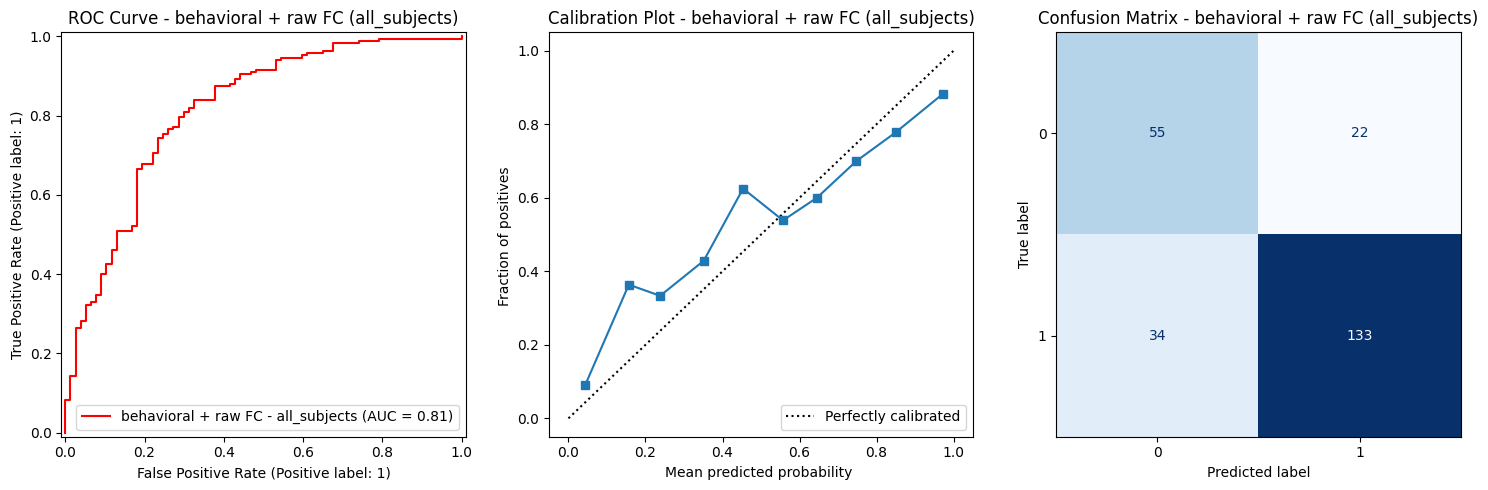

In [ ]:
calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_raw_FC', 'all_subjects')
model_1 = (calibrated_clf, report, threshold, cm)
with open(file_path+'EF_model/behavioral_raw_FC_all_subjects.pkl', 'wb') as handle:
    pickle.dump(model_1, handle)

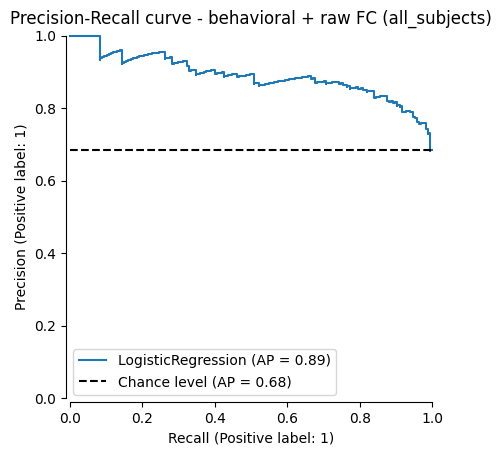

In [7]:
with open(file_path+'EF_model/behavioral_raw_FC_all_subjects.pkl', 'rb') as handle:
    model_1 = pickle.load(handle)

clf_1, report, threshold, cm = model_1

from sklearn.metrics import PrecisionRecallDisplay

def plot_PR_curve(classifier, modality_type, cohort):

  modality_data_dict = behavioral_raw_FC_dict if modality_type == 'behavioral_raw_FC' else behavioral_extracted_FC_dict
  test_x, test_y = modality_data_dict[cohort]['test_X'],  modality_data_dict[cohort]['test_y']

  title_modality = 'behavioral + raw FC' if modality_type == 'behavioral_raw_FC' else 'behavioral + extracted FC'
  display = PrecisionRecallDisplay.from_estimator(
      classifier, test_x, test_y, plot_chance_level=True, despine=True
  )
  _ = display.ax_.set_title("Precision-Recall curve - " + title_modality + " (" + cohort + ")")
  plt.show()

plot_PR_curve(clf_1, 'behavioral_raw_FC', 'all_subjects')

## female

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7551  0.9091  0.8321


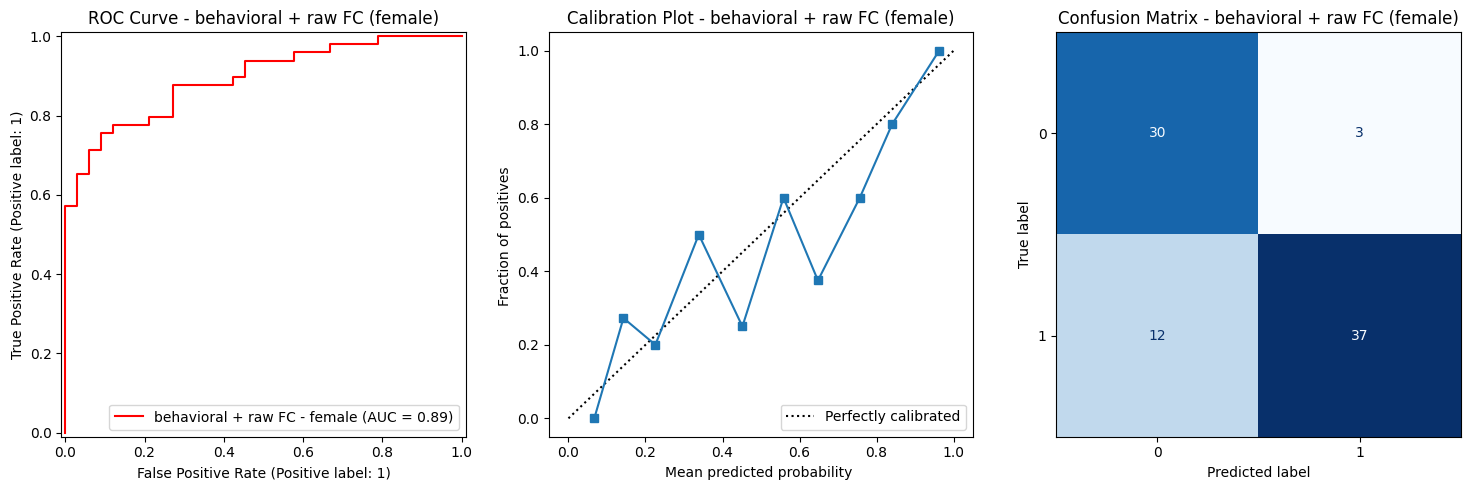

In [ ]:
calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_raw_FC', 'female')
model_2 = (calibrated_clf, report, threshold, cm)
with open(file_path+'EF_model/behavioral_raw_FC_female.pkl', 'wb') as handle:
    pickle.dump(model_2, handle)

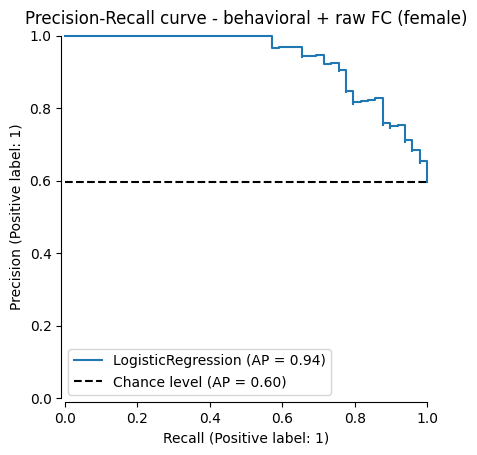

In [8]:
with open(file_path+'EF_model/behavioral_raw_FC_female.pkl', 'rb') as handle:
    clf_2, report, threshold, cm = pickle.load(handle)
plot_PR_curve(clf_2, 'behavioral_raw_FC', 'female')

## male

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7881  0.6136  0.7009


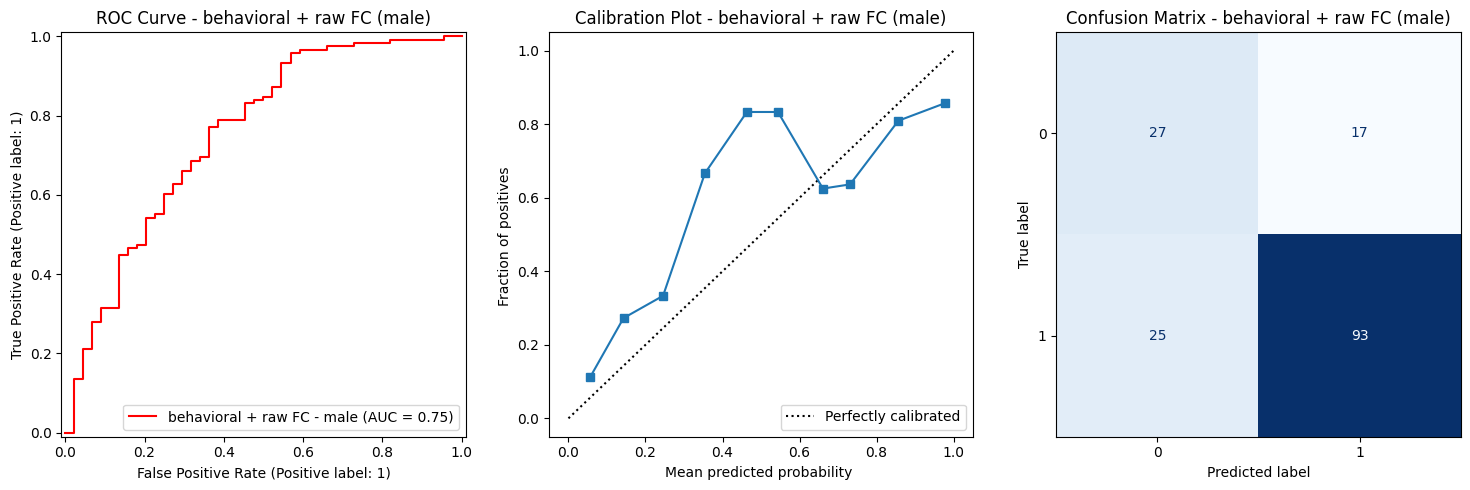

In [ ]:
calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_raw_FC', 'male')
model_3 = (calibrated_clf, report, threshold, cm)
with open(file_path+'EF_model/behavioral_raw_FC_male.pkl', 'wb') as handle:
    pickle.dump(model_3, handle)

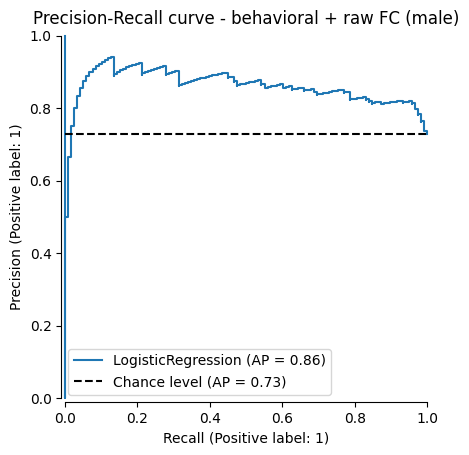

In [9]:
with open(file_path+'EF_model/behavioral_raw_FC_male.pkl', 'rb') as handle:
    clf_3, report, threshold, cm = pickle.load(handle)
plot_PR_curve(clf_3, 'behavioral_raw_FC', 'male')

# behavioral + extracted FC data

## all subjects

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.7246  0.4805  0.6025


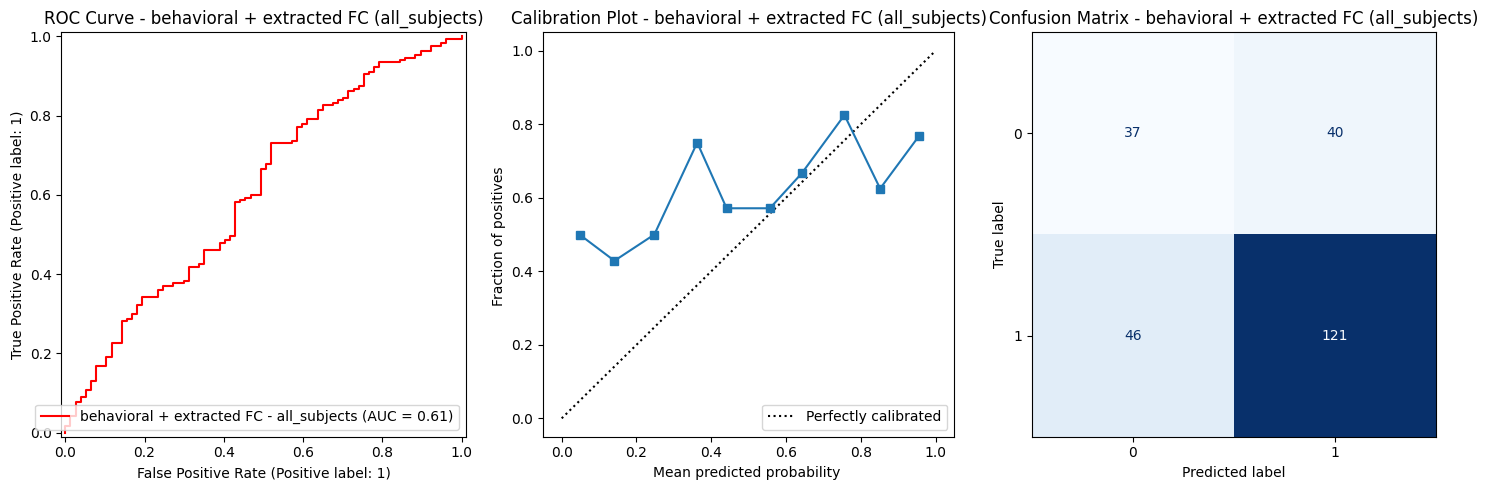

In [ ]:
calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_extracted_FC', 'all_subjects')
model_4 = (calibrated_clf, report, threshold, cm)
with open(file_path+'EF_model/behavioral_extracted_FC_all_subjects.pkl', 'wb') as handle:
    pickle.dump(model_4, handle)

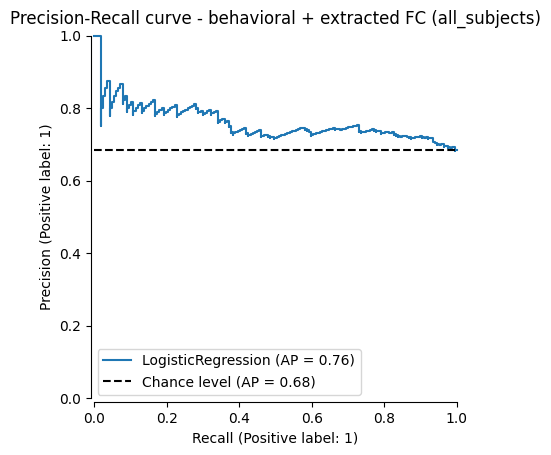

In [10]:
with open(file_path+'EF_model/behavioral_extracted_FC_all_subjects.pkl', 'rb') as handle:
    clf_4, report, threshold, cm = pickle.load(handle)
plot_PR_curve(clf_4, 'behavioral_extracted_FC', 'all_subjects')

## female

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.2449  0.9394  0.5921


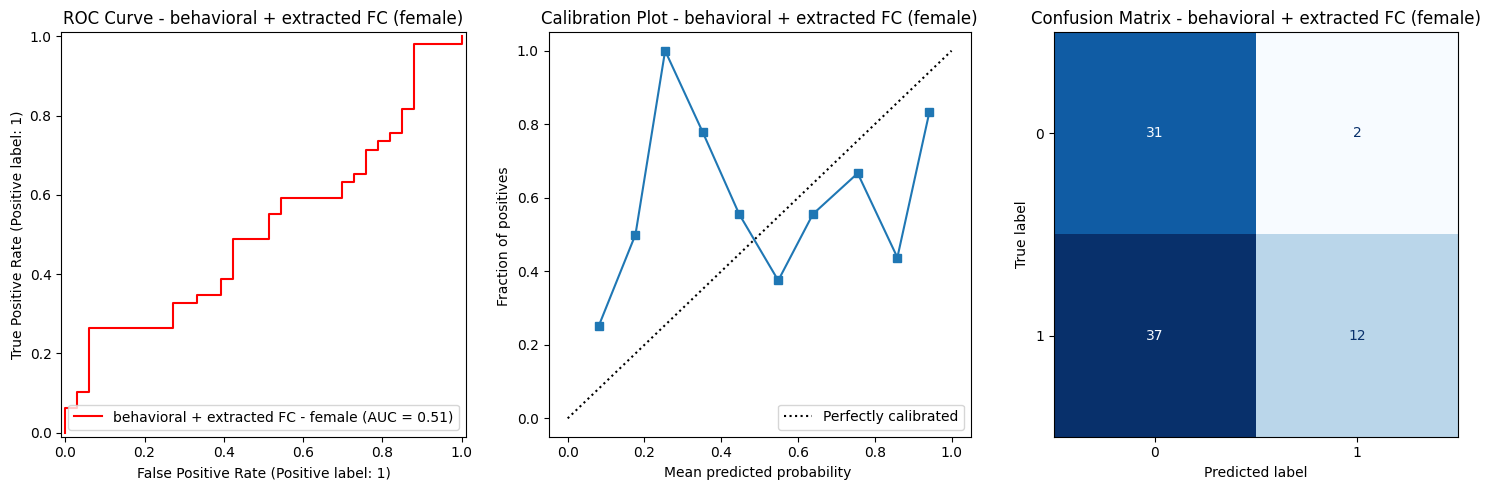

In [ ]:
 calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_extracted_FC', 'female')
 model_5 = (calibrated_clf, report, threshold, cm)
 with open(file_path+'EF_model/behavioral_extracted_FC_female.pkl', 'wb') as handle:
    pickle.dump(model_5, handle)

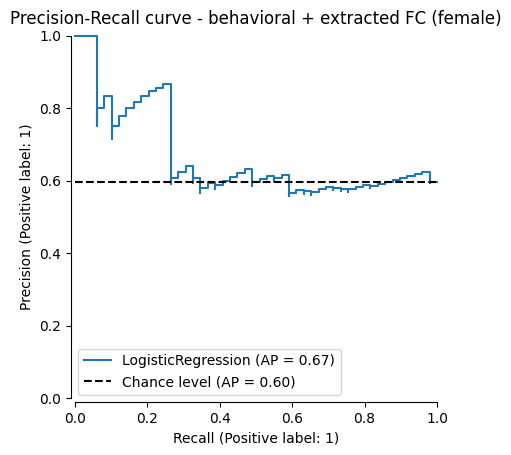

In [11]:
with open(file_path+'EF_model/behavioral_extracted_FC_female.pkl', 'rb') as handle:
    clf_5, report, threshold, cm = pickle.load(handle)
plot_PR_curve(clf_5, 'behavioral_extracted_FC', 'female')

## male

Sensitivity (Recall), Specificity, Balanced Accuracy: 0.8983  0.1364  0.5173


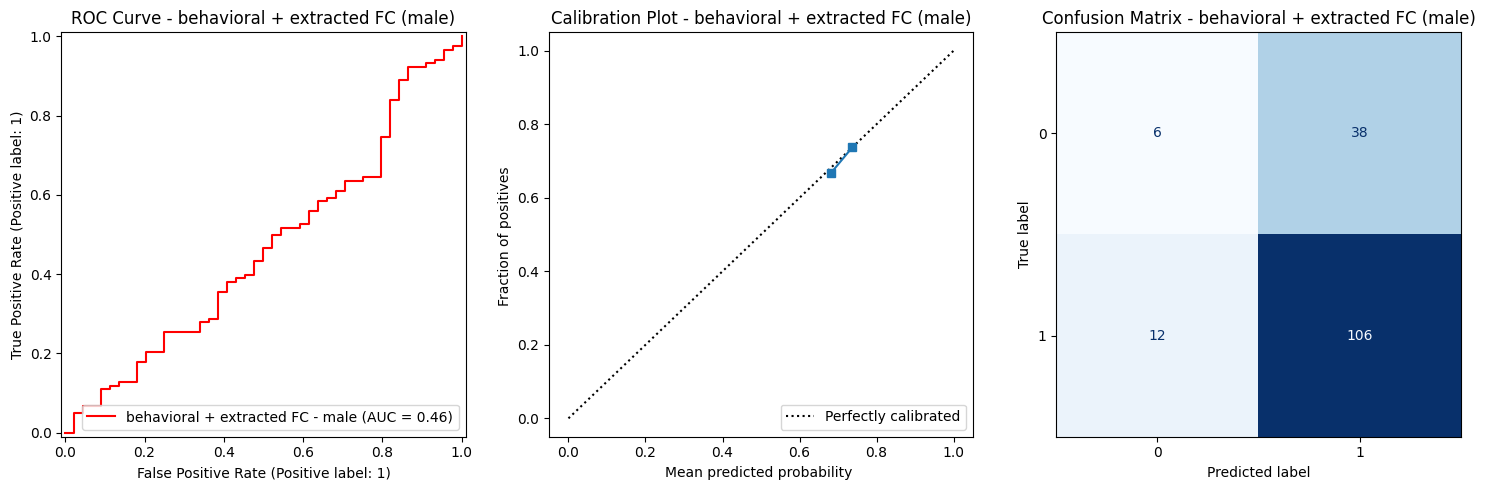

In [ ]:
calibrated_clf, report, threshold, cm = train_and_test_model('behavioral_extracted_FC', 'male')
model_6 = (calibrated_clf, report, threshold, cm)
with open(file_path+'EF_model/behavioral_extracted_FC_male.pkl', 'wb') as handle:
    pickle.dump(model_6, handle)

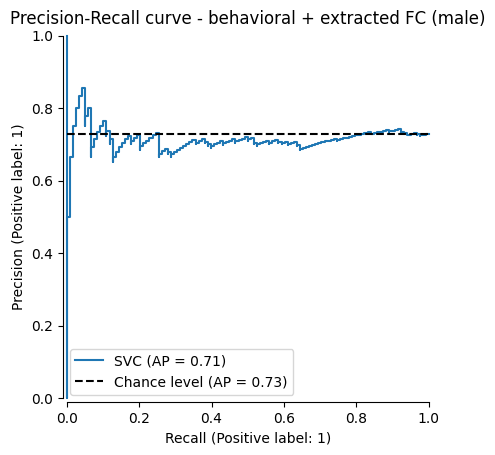

In [12]:
with open(file_path+'EF_model/behavioral_extracted_FC_male.pkl', 'rb') as handle:
    clf_6, report, threshold, cm = pickle.load(handle)
plot_PR_curve(clf_6, 'behavioral_extracted_FC', 'male')